In [1]:
import numpy as np
import pandas as pd
from scipy import stats
import sys
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import seaborn
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from sklearn.feature_selection import SelectPercentile, f_classif
from sklearn.preprocessing import MultiLabelBinarizer
porter = PorterStemmer()
lancaster=LancasterStemmer()


import json  
import zipfile  
def clean_text(list_t):
    temp = []
    for text in list_t:
        # remove backslash-apostrophe 
        text = re.sub("\'", "", text) 
        # remove everything except alphabets 
        text = re.sub("[^a-zA-Z]"," ",text) 
        # remove whitespaces 
        text = ' '.join(text.split()) 
        # convert text to lowercase 
        text = text.lower() 
        temp.append(text)
    
    return temp

def clean_description(text):
    text = re.sub('<.*?>', '', text)
    text = re.sub('\w+_\w+', '', text)
    text = re.sub(r'[^\w]', ' ', text)
    text = text.lower()
    text = ' '.join(text.split())
    return text

from nltk.corpus import stopwords
stop_words=set(stopwords.words("english"))


In [2]:
d = None  
data = None  
with zipfile.ZipFile("train.json.zip", "r") as z:
   for filename in z.namelist():  
      print(filename)  
      with z.open(filename) as f:  
         data = f.read()  
         d = json.loads(data.decode("utf-8"))

train.json


In [3]:
data = pd.DataFrame.from_dict(d)
data

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,manager_id,photos,price,street_address,interest_level
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[Dining Room, Pre-War, Laundry in Building, Di...",40.7108,7170325,-73.9539,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/7170325_3bb5ac84...,2400,145 Borinquen Place,medium
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[Doorman, Elevator, Laundry in Building, Dishw...",40.7513,7092344,-73.9722,955db33477af4f40004820b4aed804a0,[https://photos.renthop.com/2/7092344_7663c19a...,3800,230 East 44th,low
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[Doorman, Elevator, Laundry in Building, Laund...",40.7575,7158677,-73.9625,c8b10a317b766204f08e613cef4ce7a0,[https://photos.renthop.com/2/7158677_c897a134...,3495,405 East 56th Street,medium
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,5ba989232d0489da1b5f2c45f6688adc,[https://photos.renthop.com/2/7211212_1ed4542e...,3000,792 Metropolitan Avenue,medium
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[Doorman, Elevator, Fitness Center, Laundry in...",40.7439,7225292,-73.9743,2c3b41f588fbb5234d8a1e885a436cfa,[https://photos.renthop.com/2/7225292_901f1984...,2795,340 East 34th Street,low
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124000,1.0,3,92bbbf38baadfde0576fc496bd41749c,2016-04-05 03:58:33,There is 700 square feet of recently renovated...,W 171 Street,"[Elevator, Dishwasher, Hardwood Floors]",40.8433,6824800,-73.9396,a61e21da3ba18c7a3d54cfdcc247e1f8,[https://photos.renthop.com/2/6824800_0682be16...,2800,620 W 171 Street,low
124002,1.0,2,5565db9b7cba3603834c4aa6f2950960,2016-04-02 02:25:31,"2 bedroom apartment with updated kitchen, rece...",Broadway,"[Common Outdoor Space, Cats Allowed, Dogs Allo...",40.8198,6813268,-73.9578,8f90e5e10e8a2d7cf997f016d89230eb,[https://photos.renthop.com/2/6813268_1e6fcc32...,2395,3333 Broadway,medium
124004,1.0,1,67997a128056ee1ed7d046bbb856e3c7,2016-04-26 05:42:03,No Brokers Fee * Never Lived 1 Bedroom 1 Bathr...,210 Brighton 15th St,"[Dining Room, Elevator, Pre-War, Laundry in Bu...",40.5765,6927093,-73.9554,a10db4590843d78c784171a107bdacb4,[https://photos.renthop.com/2/6927093_93a52104...,1850,210 Brighton 15th St,medium
124008,1.0,2,3c0574a740154806c18bdf1fddd3d966,2016-04-19 02:47:33,Wonderful Bright Chelsea 2 Bedroom apartment o...,West 21st Street,"[Pre-War, Laundry in Unit, Dishwasher, No Fee,...",40.7448,6892816,-74.0017,c3cd45f4381ac371507090e9ffabea80,[https://photos.renthop.com/2/6892816_1a8d087a...,4195,350 West 21st Street,medium


In [4]:
data['features'] = data['features'].apply(lambda x : clean_text(x))

In [5]:
ps = PorterStemmer()
def porter_stemmer(list_t):
    temp = []
    for i in list_t:
        temp.append(ps.stem(i))
#     print(temp)
    return temp

data['stemmed_features'] = data['features'].apply(porter_stemmer)

In [6]:
dic = {}
for i in range(len(data)):
    for j in data["stemmed_features"][i]:
        if j in dic:
            dic[j]+=1
        else:
            dic.setdefault(j,1)

In [7]:
dic = {key:val for key, val in dic.items() if val > 5000}
values = dic.values()

{'whiskers': [<matplotlib.lines.Line2D at 0x7f27afa121d0>,
 'caps': [<matplotlib.lines.Line2D at 0x7f27afa12650>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f27b587abd0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f27afa23c10>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f27afa23250>],
 'means': []}

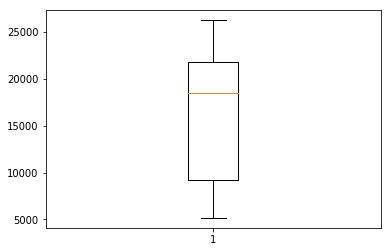

In [8]:
# dic = pd.DataFrame.from_records([dic])
plt.boxplot(values)

In [9]:
keys = list(dic.keys())

In [10]:
for i in keys:
    data[i] = 0

In [11]:
data

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,...,hardwood floor,dogs allow,cats allow,doorman,elev,no fe,laundry in unit,fitness cent,roof deck,outdoor spac
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[dining room, pre war, laundry in building, di...",40.7108,7170325,-73.9539,...,0,0,0,0,0,0,0,0,0,0
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[doorman, elevator, laundry in building, dishw...",40.7513,7092344,-73.9722,...,0,0,0,0,0,0,0,0,0,0
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[doorman, elevator, laundry in building, laund...",40.7575,7158677,-73.9625,...,0,0,0,0,0,0,0,0,0,0
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,...,0,0,0,0,0,0,0,0,0,0
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[doorman, elevator, fitness center, laundry in...",40.7439,7225292,-73.9743,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124000,1.0,3,92bbbf38baadfde0576fc496bd41749c,2016-04-05 03:58:33,There is 700 square feet of recently renovated...,W 171 Street,"[elevator, dishwasher, hardwood floors]",40.8433,6824800,-73.9396,...,0,0,0,0,0,0,0,0,0,0
124002,1.0,2,5565db9b7cba3603834c4aa6f2950960,2016-04-02 02:25:31,"2 bedroom apartment with updated kitchen, rece...",Broadway,"[common outdoor space, cats allowed, dogs allo...",40.8198,6813268,-73.9578,...,0,0,0,0,0,0,0,0,0,0
124004,1.0,1,67997a128056ee1ed7d046bbb856e3c7,2016-04-26 05:42:03,No Brokers Fee * Never Lived 1 Bedroom 1 Bathr...,210 Brighton 15th St,"[dining room, elevator, pre war, laundry in bu...",40.5765,6927093,-73.9554,...,0,0,0,0,0,0,0,0,0,0
124008,1.0,2,3c0574a740154806c18bdf1fddd3d966,2016-04-19 02:47:33,Wonderful Bright Chelsea 2 Bedroom apartment o...,West 21st Street,"[pre war, laundry in unit, dishwasher, no fee,...",40.7448,6892816,-74.0017,...,0,0,0,0,0,0,0,0,0,0


In [12]:
for index,words in enumerate(data['stemmed_features']):
    for i in words:
        if i in keys:
            data[i][index] = 1

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [13]:
data

,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,...,hardwood floor,dogs allow,cats allow,doorman,elev,no fe,laundry in unit,fitness cent,roof deck,outdoor spac
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[dining room, pre war, laundry in building, di...",40.7108,7170325,-73.9539,...,1,1,1,0,0,0,0,0,0,0
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[doorman, elevator, laundry in building, dishw...",40.7513,7092344,-73.9722,...,1,0,0,1,1,1,0,0,0,0
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[doorman, elevator, laundry in building, laund...",40.7575,7158677,-73.9625,...,1,0,0,1,1,0,1,0,0,0
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,...,0,0,0,0,0,0,0,0,0,0
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[doorman, elevator, fitness center, laundry in...",40.7439,7225292,-73.9743,...,0,0,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124000,1.0,3,92bbbf38baadfde0576fc496bd41749c,2016-04-05 03:58:33,There is 700 square feet of recently renovated...,W 171 Street,"[elevator, dishwasher, hardwood floors]",40.8433,6824800,-73.9396,...,1,0,0,0,1,0,0,0,0,0
124002,1.0,2,5565db9b7cba3603834c4aa6f2950960,2016-04-02 02:25:31,"2 bedroom apartment with updated kitchen, rece...",Broadway,"[common outdoor space, cats allowed, dogs allo...",40.8198,6813268,-73.9578,...,0,1,1,1,1,1,0,0,0,0
124004,1.0,1,67997a128056ee1ed7d046bbb856e3c7,2016-04-26 05:42:03,No Brokers Fee * Never Lived 1 Bedroom 1 Bathr...,210 Brighton 15th St,"[dining room, elevator, pre war, laundry in bu...",40.5765,6927093,-73.9554,...,1,1,1,0,1,1,1,0,0,0
124008,1.0,2,3c0574a740154806c18bdf1fddd3d966,2016-04-19 02:47:33,Wonderful Bright Chelsea 2 Bedroom apartment o...,West 21st Street,"[pre war, laundry in unit, dishwasher, no fee,...",40.7448,6892816,-74.0017,...,0,0,0,0,0,1,1,0,0,1


In [14]:
data['cleaned_description'] = data['description'].apply(clean_description)

In [15]:
for index, plot in enumerate(data['cleaned_description']):
    temp = plot.split()
    temp_list = ''
    for i in temp:
        if i not in stop_words:
            temp_list = temp_list + ' ' + i
    data['cleaned_description'][index] = temp_list
# data['cleaned_description']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [16]:
data['cleaned_description_porter'] = ''

In [17]:
def stemSentence_porter(sentence):
    token_words=word_tokenize(sentence)
    stem_sentence=[]
    for word in token_words:
        stem_sentence.append(porter.stem(word))
        stem_sentence.append(" ")
    return "".join(stem_sentence)

def token_plot_porter(data):
    for index,plot in enumerate(data['cleaned_description']):
        data['cleaned_description_porter'][index] = stemSentence_porter(plot)
    return data

In [18]:
data = token_plot_porter(data)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [19]:
dic = {}
for i in data['cleaned_description_porter']:
    token_words=word_tokenize(i)
    for j in range(len(token_words)-1):
        temp = token_words[j] + ' ' +token_words[j+1]
        if temp not in dic:
            dic.update({temp:1})
        else:
            dic[temp] += 1

In [20]:
features = list(data.axes[1][:])

In [21]:
dic = dict((k, v) for k, v in dic.items() if v >= 7000 and v <=16000)
dic_filtered = {k: v for k, v in dic.items() if k not in features}
dic_filtered = {k: v for k, v in sorted(dic_filtered.items(), key=lambda item: item[1], reverse = True)}
dic_filtered

{'stainless steel': 15951,
 'steel applianc': 13557,
 'new york': 10404,
 'high ceil': 9336,
 'closet space': 8448,
 'live room': 7827,
 'real estat': 7777,
 'call text': 7710,
 'washer dryer': 7480,
 'apart featur': 7006}

In [22]:
keys = list(dic_filtered.keys())
for i in keys:
    data[i] = 0

In [23]:
for index,sentence in enumerate(data['cleaned_description_porter']):
    token_words=sentence.split(' ')
    for i in range( len(token_words) - 1 ):
        temp = token_words[i] + ' ' + token_words[i+1]
#         print(temp)
        if temp in keys:
            data[temp][index] = 1
data
    


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


,bathrooms,bedrooms,building_id,created,description,display_address,features,latitude,listing_id,longitude,...,stainless steel,steel applianc,new york,high ceil,closet space,live room,real estat,call text,washer dryer,apart featur
4,1.0,1,8579a0b0d54db803821a35a4a615e97a,2016-06-16 05:55:27,Spacious 1 Bedroom 1 Bathroom in Williamsburg!...,145 Borinquen Place,"[dining room, pre war, laundry in building, di...",40.7108,7170325,-73.9539,...,0,0,0,0,1,0,0,0,0,1
6,1.0,2,b8e75fc949a6cd8225b455648a951712,2016-06-01 05:44:33,BRAND NEW GUT RENOVATED TRUE 2 BEDROOMFind you...,East 44th,"[doorman, elevator, laundry in building, dishw...",40.7513,7092344,-73.9722,...,0,0,0,0,0,0,0,1,0,0
9,1.0,2,cd759a988b8f23924b5a2058d5ab2b49,2016-06-14 15:19:59,**FLEX 2 BEDROOM WITH FULL PRESSURIZED WALL**L...,East 56th Street,"[doorman, elevator, laundry in building, laund...",40.7575,7158677,-73.9625,...,1,1,0,0,1,0,0,1,0,0
10,1.5,3,53a5b119ba8f7b61d4e010512e0dfc85,2016-06-24 07:54:24,A Brand New 3 Bedroom 1.5 bath ApartmentEnjoy ...,Metropolitan Avenue,[],40.7145,7211212,-73.9425,...,0,1,0,0,0,0,0,0,1,1
15,1.0,0,bfb9405149bfff42a92980b594c28234,2016-06-28 03:50:23,Over-sized Studio w abundant closets. Availabl...,East 34th Street,"[doorman, elevator, fitness center, laundry in...",40.7439,7225292,-73.9743,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124000,1.0,3,92bbbf38baadfde0576fc496bd41749c,2016-04-05 03:58:33,There is 700 square feet of recently renovated...,W 171 Street,"[elevator, dishwasher, hardwood floors]",40.8433,6824800,-73.9396,...,1,1,1,0,0,0,1,1,0,0
124002,1.0,2,5565db9b7cba3603834c4aa6f2950960,2016-04-02 02:25:31,"2 bedroom apartment with updated kitchen, rece...",Broadway,"[common outdoor space, cats allowed, dogs allo...",40.8198,6813268,-73.9578,...,0,0,1,0,0,0,0,0,0,0
124004,1.0,1,67997a128056ee1ed7d046bbb856e3c7,2016-04-26 05:42:03,No Brokers Fee * Never Lived 1 Bedroom 1 Bathr...,210 Brighton 15th St,"[dining room, elevator, pre war, laundry in bu...",40.5765,6927093,-73.9554,...,1,1,0,0,1,0,0,0,0,1
124008,1.0,2,3c0574a740154806c18bdf1fddd3d966,2016-04-19 02:47:33,Wonderful Bright Chelsea 2 Bedroom apartment o...,West 21st Street,"[pre war, laundry in unit, dishwasher, no fee,...",40.7448,6892816,-74.0017,...,0,0,0,0,0,0,1,0,1,0


In [25]:
data.to_csv('cleaned_textfeatures_added.csv')